In [23]:
import sys
!{sys.executable} -m pip install 'sktime[all_extras]'

# Combining tsbootstrap with sktime

This notebook demonstrates how tsbootstraps integrates with sktime. To demonstrate it, we forecast the airline time series. 

### You learn
* How you can use bootstrapping to create probabilistic forecasts
* How you can integrate tsbootstrap with sktime

### Prerequisites
* You should be familiar with the sktime forecasting pipelines.
* You should be familiar with the basic ideas of bootstrapping

## Integration of tsbootstrap with sktime

To us tsbootstrap together with sktime, we perform three steps:

1. we create the bootstrapper, we would like to use. In this example, we use a `MovingBlockBoostrap` with a `block_length` of 10 and create `10` bootstraps. The created tsbootstrap object, we pass to the `TSBoostrapAdapter` of sktime. 


In [24]:
from sktime.transformations.bootstrap import TSBootstrapAdapter
from tsbootstrap import MovingBlockBootstrap, MovingBlockBootstrapConfig

tsbootstrap_opject = MovingBlockBootstrap(MovingBlockBootstrapConfig(10, n_bootstraps=10))
bootstrap = TSBootstrapAdapter(tsbootstrap_opject)

2. we create the sktime based forecaster. In particular, we create first the `BaggingForecaster` and embed in afterwards into a forecasting pipeline that contains additional preprocessing steps. 
* The task of the `BaggingForecaster` is to combine a boostrap algorithm and a forecasting algorithm. Internally, it creates one forecaster for each bootstrap the boostrapping algorithm is creating. 
* As preprocessing steps, we add a `LogTransformer` and a `Deseasonalizer`. 
    * The `LogTransformer` is responsible to make the time series additive.
    * The `Deaseasonalizer` removes the yearly seasonality from the time series. 
    * For more information, take a look at https://github.com/sktime/sktime/blob/main/examples/03_transformers.ipynb

In [25]:
from sktime.forecasting.compose import BaggingForecaster
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster

bagging_forecaster = BaggingForecaster(bootstrap, PolynomialTrendForecaster(degree=2))
forecaster =  LogTransformer() * Deseasonalizer(sp=12) * bagging_forecaster


3. we fit the forecaster to the training data. Therefore, we first load the data, split it into train and test data. Afterwards, we can call fit on the forecater.

In [26]:
from sktime.datasets import load_airline
from sktime.split import temporal_train_test_split

y =load_airline()

y_train, y_test = temporal_train_test_split(y)

forecaster.fit(y_train)


TransformedTargetForecaster(steps=[LogTransformer(), Deseasonalizer(sp=12),
                                   BaggingForecaster(bootstrap_transformer=TSBootstrapAdapter(tsbootstrapper=MovingBlockBootstrap(config=MovingBlockBootstrapConfig(block_length=10))),
                                                     forecaster=PolynomialTrendForecaster(degree=2))])

After fitting the forecaster, we can use it to create probabilistic forecasts.

In [27]:
import numpy as np

pred_interval = forecaster.predict_interval(fh=y_test.index)
forecast = forecaster.predict(fh=y_test.index)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

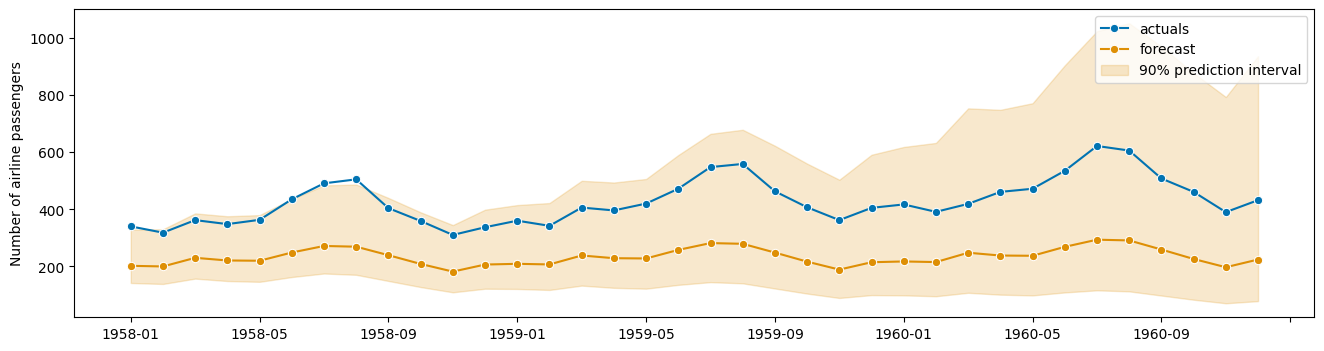

In [28]:
from sktime.utils.plotting import plot_series
plot_series(y_test, forecast, labels=["actuals", "forecast"], pred_interval=pred_interval)
